# Using the same method with LF and HF for breaking index n=2
# For n=2: $\dot{P}_{1}=\dot{P}_{2}, \dot{P}_{2}=1.1 \times 10^{-15} P_{2}^{4 / 3}, and P_{birth}=P_{obs}-\dot{P}_{int}t_{random}$  instead of n=3: $\dot{P}_{1} P_{1}=\dot{P}_{2} P_{2} ,\dot{P}_{2}=1.1 \times 10^{-5} P_{2}^{4 / 3}, and P_{birth}=P_{obs}\sqrt{1-2\dot{P}_{int}t_{random} / P_{obs}}$


In [134]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

slo_data=pd.read_csv('slo_data.txt',sep=' ')
rec_data=pd.read_csv('rec_data.txt',sep=' ')
data=pd.read_csv('data.txt',sep=' ')
#data and rec_data ['name','pmra','pmdec','gl','gb','p0','p1','pb','dl','m','merr','mc','e']
#slo_data ['m','merr']
del rec_data['p0']
del rec_data['p1']
del rec_data['pb']
rec_bns=rec_data.iloc[27:,:]

file=open('PSR_BNSmass_New.txt')
data=file.readlines()
with open('PSR.txt','w') as m:
    for line in data:
        m.write(' '.join(line.split()))
        m.write('\n')
data_psr_bns=pd.read_csv('PSR.txt',sep=' ',header=None,names=['name','m','merr','mc','mcerr','mt','mterr','p0','p1','pb','e'])
psr_rec=(pd.concat([data_psr_bns.iloc[0:-1,:],rec_bns.iloc[:,1:6].reset_index(drop=True)],axis=1)).reset_index(drop=True)

nswd_data=pd.read_excel('NSmass_precise.xlsx')
ex_dat=pd.read_csv('ex_dat.txt',sep=';',names=['nu','nam','pmra','pmdec','gl','gb','dl','nan'])
del ex_dat['nu']
del ex_dat['nan']
nswd_rec=(pd.concat([(nswd_data.iloc[:,:]),(ex_dat.iloc[:,:]).reset_index(drop=True)],axis=1)).reset_index(drop=True)
del nswd_rec['ref']
del nswd_rec['type']
del nswd_rec['nam']
nswd_recdat=nswd_rec.iloc[:-1,:]
nswd_slodat=nswd_rec.iloc[24:,:]

import GalDynPsr 
import numpy as np
nswd_rec_expl=np.zeros(len(nswd_recdat['gl']))
for i in range(len(nswd_recdat['gl'])):
    nswd_rec_expl[i]=GalDynPsr.modelA.Expl(nswd_recdat['gl'][i], 0, nswd_recdat['gb'][i], 0, nswd_recdat['dl'][i], 0) 
nswd_rec_exz=np.zeros(len(nswd_recdat['gl']))
for i in range(len(nswd_recdat['gl'])):
    nswd_rec_exz[i]=GalDynPsr.modelA.Exz(nswd_recdat['gl'][i], 0, nswd_recdat['gb'][i], 0, nswd_recdat['dl'][i], 0) 
nswd_rec_shk=np.zeros(len(nswd_recdat['gl']))
for i in range(len(nswd_recdat['gl'])):
    nswd_rec_shk[i]=GalDynPsr.Shk.Exshk(nswd_recdat['dl'][i], 0,nswd_recdat['pmra'][i],0,nswd_recdat['pmdec'][i],0) 

Gal_int=GalDynPsr.pdotint.Pdotint(nswd_rec_expl,nswd_rec_exz,nswd_rec_shk,nswd_recdat['p1'],nswd_recdat['p0'])
Gal_int=pd.DataFrame(Gal_int,columns=['pdot_int'])

psr_rec_expl=np.zeros(len(psr_rec['gl']))
for i in range(len(psr_rec['gl'])):
    psr_rec_expl[i]=GalDynPsr.modelA.Expl(psr_rec['gl'][i], 0, psr_rec['gb'][i], 0, psr_rec['dl'][i], 0)
psr_rec_exz=np.zeros(len(psr_rec['gl']))
for i in range(len(psr_rec['gl'])):
    psr_rec_exz[i]=GalDynPsr.modelA.Exz(psr_rec['gl'][i], 0, psr_rec['gb'][i], 0, psr_rec['dl'][i], 0) 
psr_rec_shk=np.zeros(len(psr_rec['gl']))
for i in range(len(psr_rec['gl'])):
    psr_rec_shk[i]=GalDynPsr.Shk.Exshk(psr_rec['dl'][i], 0,psr_rec['pmra'][i],0,psr_rec['pmdec'][i],0) 

Gal_psr_int=GalDynPsr.pdotint.Pdotint(psr_rec_expl,psr_rec_exz,psr_rec_shk,psr_rec['p1'],psr_rec['p0'])    
Gal_psr_int=pd.DataFrame(Gal_psr_int,columns=['pdot_int'])

#####
rec_nswd=(pd.concat([nswd_recdat,Gal_int.reset_index(drop=True)],axis=1)).reset_index(drop=True)
rec_psr=(pd.concat([psr_rec,Gal_psr_int.reset_index(drop=True)],axis=1)).reset_index(drop=True)
rec_nswd['pdot_int'][22]=1.54*10**(-20)
rec_nswd['pdot_int'][9]=5.56625*10**(-21)
rec_psr['pdot_int'][9]=4.985*10**(-18)
rec_psr['pdot_int'][10]=1.10*10**(-19)

import astropy
import astropy.units as u 

def pdot_mag(p,B_mag):
    """
    get Pdot for a constant magnetic field 
    paramaters:
    -------
    p: the period, uni, s
    B_mag: the value of constant magnetic field, unit: G 
    -------
    return:
    p_dot
    
    """
    return (B_mag / 3.2e19)**2 / p

def pdot_year(p,year):
    """
    get Pdot for a constant age
    paramaters:
    -------
    p: the period, uni, s
    year: the value of the constant age, unit: yr
    -------
    return:
    p_dot
    
    """
    return 0.5*p/(year*365*24*60*60)


def t_c(p,pdot):
    """
    callculate the characteristic age given p and pdot
    paramaters:
    -----
    p,pdot: i.e. period and period derivative; units= s , none
    return :
    the characteristic age; unit = Gyr
    
    """
    return (p/(1*pdot))*u.s.to(u.Gyr) #unit Gyr

def p_pdot_forb(p):
    
    """
    spin-up line
    paramaters:
    -----
    p: period ,unit: s
    return: p_dot
    """
    return 1.1*10**(-15)*p**(4/3)

def p_mid_sol(p_dot):
    """
    slove the intersection of two lines between the spin-up line and constatnt magnetic field lines to get period
    paramaters:
    ------
    input: p, p_dot, i.e. intrinsic period and period derivative
    return: 
    p_intsect, i.e. the period at the intersection between the spin-up line and the evolution trace of constant magnetic field
    """
    return (p_dot / ((1.1)*10**(-15)) )**(3/4)  


def p_dot_mid_sol(p_dot):
    """
    slove the intersection of two lines between the spin-up line and constatnt magnetic field lines to get pdot
    paramaters:
    ------
    input: p, p_dot, i.e. intrinsic period and period derivative
    return: 
    p_dot_intsect, i.e. the period derivative at the intersection between the spin-up line and the evolution trace of constant magnetic field
    """
    return p_dot 

tc=t_c(rec_nswd['p0'],rec_nswd['pdot_int'])
tc=pd.DataFrame(tc,columns=['tc'])
rec_nswd=pd.concat([rec_nswd,tc],axis=1)

tc_psr=t_c(rec_psr['p0'],rec_psr['pdot_int'])
tc_psr=pd.DataFrame(tc_psr,columns=['tc'])
rec_psr=pd.concat([rec_psr,tc_psr],axis=1)

birth_psr=np.zeros((len(rec_psr['p0']),2))
birth_psr[:,0]=p_mid_sol(rec_psr['pdot_int'])
birth_psr[:,1]=p_dot_mid_sol(rec_psr['pdot_int'])

birth=np.zeros((len(rec_nswd['p0']),2))
birth[:,0]=p_mid_sol(rec_nswd['pdot_int'])
birth[:,1]=p_dot_mid_sol(rec_nswd['pdot_int'])

for i in range(len(birth)):
    birth[i,0] = max(birth[i,0],0.001)
    birth[i,1] = rec_nswd['pdot_int'][i]

for i in range(len(birth_psr)):
    birth_psr[i,0] = max(birth_psr[i,0],0.001)
    birth_psr[i,1] = rec_psr['pdot_int'][i] 

birth_data=pd.DataFrame(birth,columns=['p0_birth','p1_birth'])
birth_psr_data=pd.DataFrame(birth_psr,columns=['p0_birth','p1_birth'])
rec_nswd=(pd.concat([rec_nswd,birth_data.reset_index(drop=True)],axis=1)).reset_index(drop=True)
rec_psr=(pd.concat([rec_psr,birth_psr_data.reset_index(drop=True)],axis=1)).reset_index(drop=True)

tc_b=t_c(rec_nswd['p0_birth'],rec_nswd['p1_birth'])
tc_b_psr=t_c(rec_psr['p0_birth'],rec_psr['p1_birth'])
tc_b=pd.DataFrame(tc_b,columns=['tc_b'])
tc_b_psr=pd.DataFrame(tc_b_psr,columns=['tc_b'])
rec_nswd=pd.concat([rec_nswd,tc_b],axis=1)
rec_psr=pd.concat([rec_psr,tc_b_psr],axis=1)

tmax_nswd=(rec_nswd['tc']-rec_nswd['tc_b'])
tmax_psr=(rec_psr['tc']-rec_psr['tc_b'])

In [136]:
tmax_nswd=np.array(tmax_nswd)
tmax_psr=np.array(tmax_psr)


for i in range(len(tmax_nswd)):
    if tmax_nswd[i] > 11: #the age of milky way 11 Gyr
        tmax_nswd[i]=11
        #calculate the period period using t_random and p_dot 
        rec_nswd['p0_birth'][i]=(-11*u.Gyr.to(u.s))*rec_nswd['p1_birth'][i] + rec_nswd['p0'][i]
tmax_nswd=pd.DataFrame(tmax_nswd,columns=['tmax'])

for i in range(len(tmax_psr)):
    if tmax_psr[i]>11: #the age of milky way 11 Gyr
        tmax_psr[i]=11
        #calculate the period period using t_random and p_dot 
        rec_psr['p0_birth'][i]=(-11*u.Gyr.to(u.s))*rec_psr['p1_birth'][i] + rec_psr['p0'][i]
tmax_psr=pd.DataFrame(tmax_psr,columns=['tmax'])

rec_nswd=pd.concat([rec_nswd,tmax_nswd],axis=1)
rec_psr=pd.concat([rec_psr,tmax_psr],axis=1)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


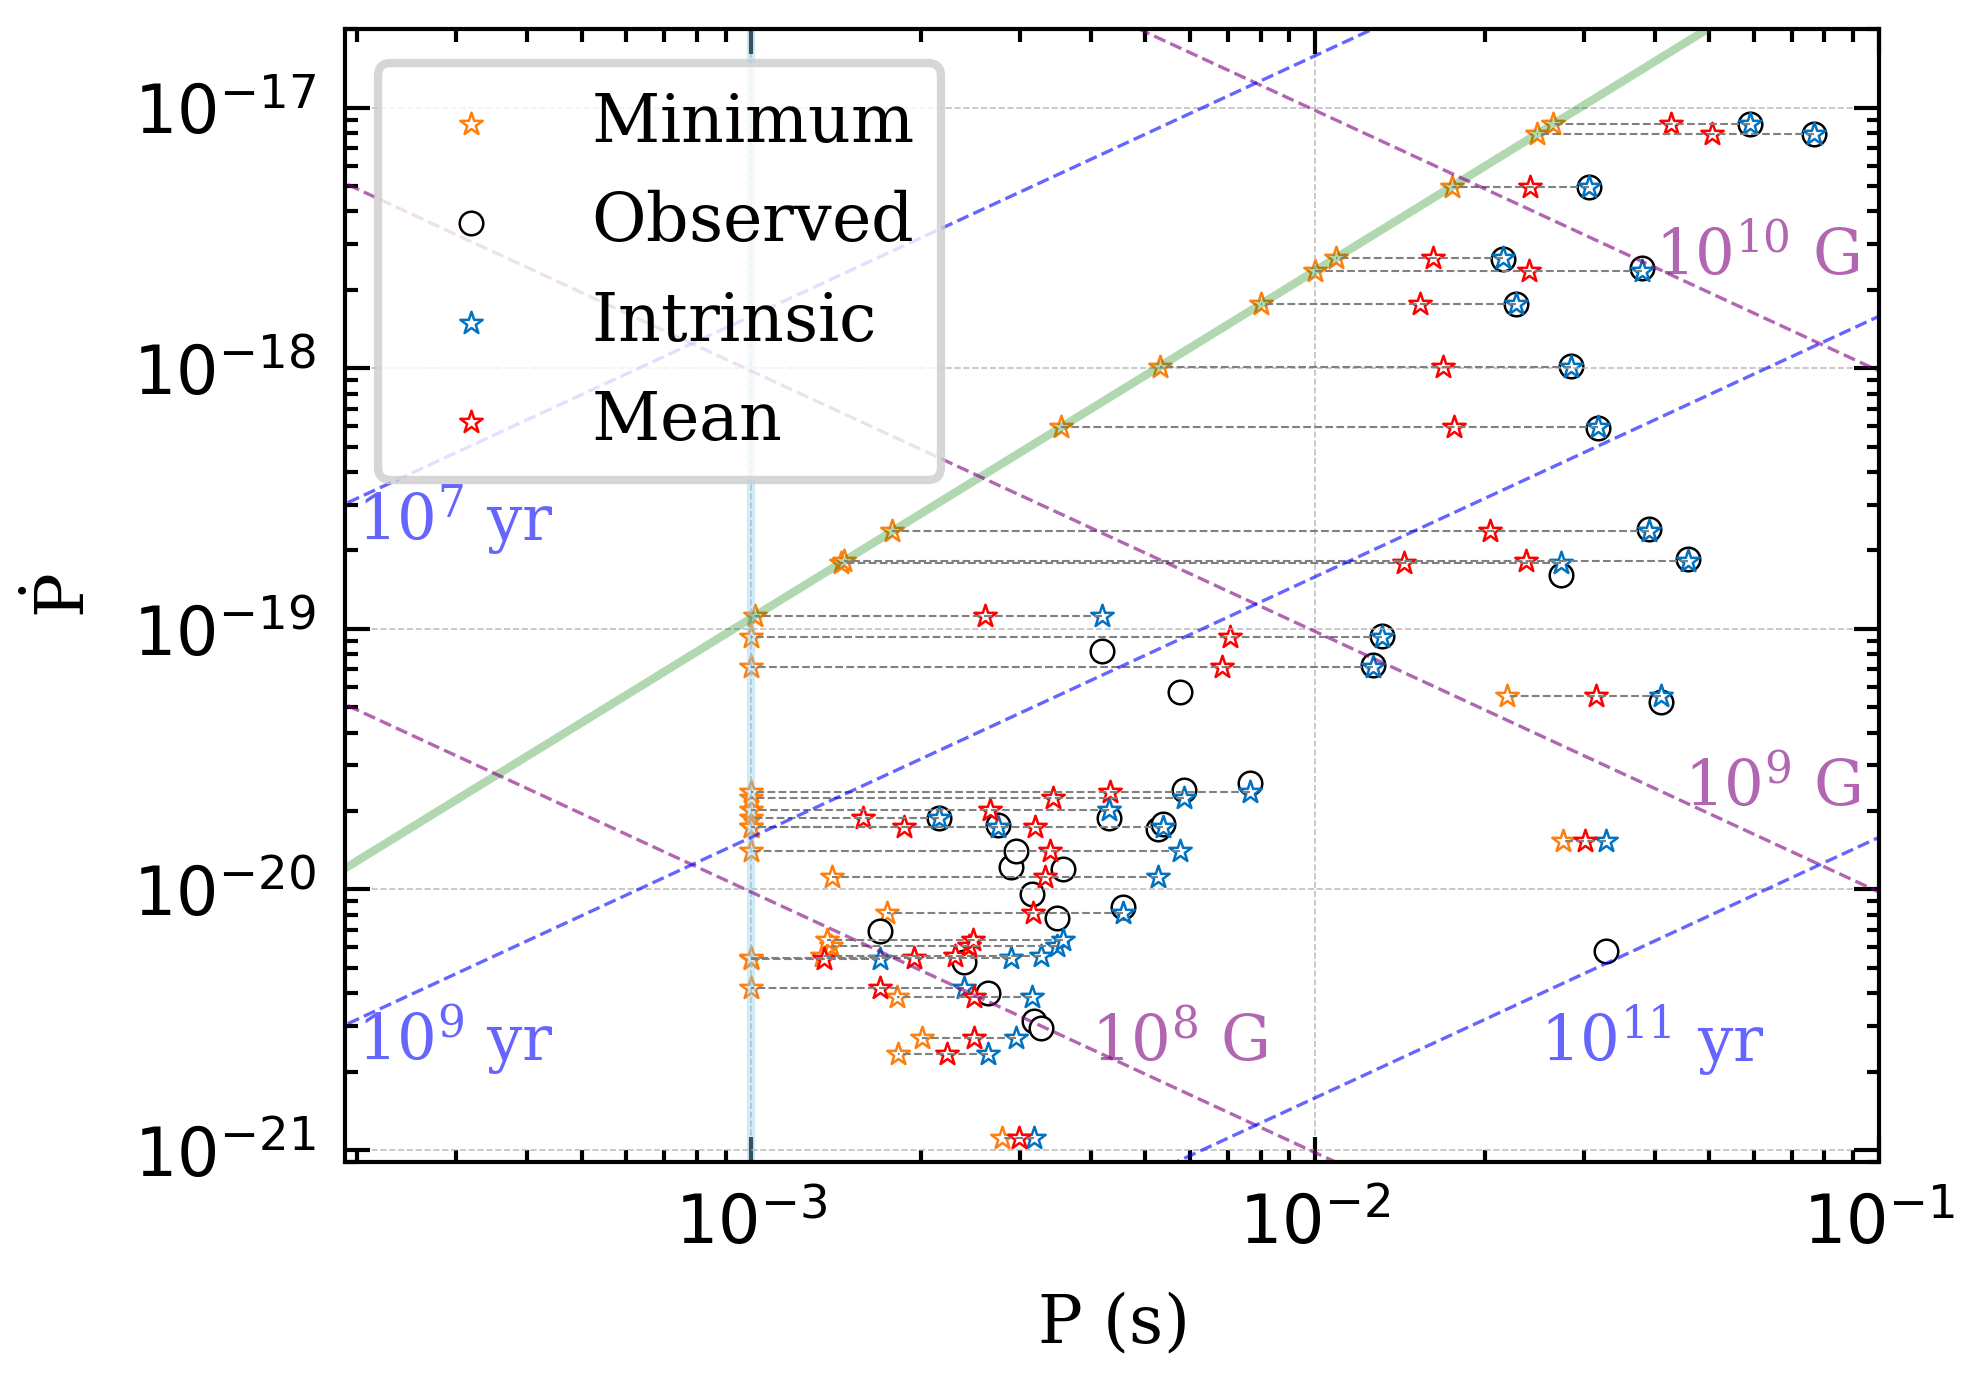

In [10]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['science','ieee','no-latex'])
p_arr=np.linspace(0.0001,20,10000)
p=np.linspace(0.0001,20,10000)
fs=7.5
ybeg=0.001
al=0.6
pdot_arr=p_pdot_forb(p_arr)

plt.figure()
#plt.grid(b=True, which='minor',linestyle='--',lw=0.2,alpha=0.5)
plt.grid(b=True,linestyle='--',lw=0.2,alpha=0.8)

#plt.scatter(p_min,pdot_min,marker='o',facecolor='white',edgecolors='green',lw=0.3,s=8,label=r'$\rm{birth_{min}}$')
plt.plot( p_arr, pdot_arr,c='green',alpha=0.3)

#spin_up_limit p0-p1
plt.scatter(rec_psr['p0_birth'], rec_psr['pdot_int'],marker='*',facecolor='white',edgecolors='#ff7f0e',lw=0.3,s=8,label=r'$\rm{Minimum}$')
plt.scatter(rec_nswd['p0_birth'], rec_nswd['pdot_int'],marker='*',facecolor='white',edgecolors='#ff7f0e',lw=0.3,s=8)

#obsderved p0-p1
plt.scatter(rec_psr['p0'],rec_psr['p1'],marker='o',facecolor='white',edgecolors='k',lw=0.3,s=8,label=r'$\rm{Observed}$')
plt.scatter(rec_nswd['p0'],rec_nswd['p1'],marker='o',facecolor='white',edgecolors='k',lw=0.3,s=8)

#Intrinsic p0-p1
plt.scatter(rec_psr['p0'],rec_psr['pdot_int'],marker='*',facecolor='white',edgecolors='#0072c1',lw=0.3,s=8,label=r'$\rm{Intrinsic}$')
plt.scatter(rec_nswd['p0'],rec_nswd['pdot_int'],marker='*',facecolor='white',edgecolors='#0072c1',lw=0.3,s=8)

#mean p0-p1
plt.scatter(0.5*(rec_psr['p0']+rec_psr['p0_birth']),rec_psr['pdot_int'],marker='*',facecolor='white',edgecolors='red',lw=0.3,s=8,label=r'$\rm{Mean}$')
plt.scatter(0.5*(rec_nswd['p0']+rec_nswd['p0_birth']),rec_nswd['pdot_int'],marker='*',facecolor='white',edgecolors='red',lw=0.3,s=8)


#plot dash line between spin_up_limit and Intrinsic
for i in range(len(rec_psr['p0'])):
    plt.plot([rec_psr['p0'][i],rec_psr['p0_birth'][i]],[rec_psr['pdot_int'][i],rec_psr['pdot_int'][i]],linewidth=0.25,ls='--',color='grey',alpha=1)
for i in range(len(rec_nswd['p0'])):
    plt.plot([rec_nswd['p0'][i],rec_nswd['p0_birth'][i]],[rec_nswd['pdot_int'][i],rec_nswd['pdot_int'][i]],linewidth=0.25,ls='--',color='grey',alpha=1)

###plot age line and magnitude line######
plt.plot(p,pdot_mag(p,10**8),color='purple',ls='--',lw=0.4,alpha=al)
plt.plot(p,pdot_mag(p,10**9),color='purple',ls='--',lw=0.4,alpha=al)
plt.plot(p,pdot_mag(p,10**10),color='purple',ls='--',lw=0.4,alpha=al)
plt.text(4*10**(-3), 2.2*10**(-21), r'$\rm{10^{8} \,\, G}$', fontsize=fs, color='purple',alpha=al)
plt.text(4.5*10**(-2), 2.1*10**(-20), r'$\rm{10^{9} \,\, G}$', fontsize=fs, color='purple',alpha=al)
plt.text(4*10**(-2), 2.3*10**(-18), r'$\rm{10^{10} \,\, G}$', fontsize=fs, color='purple',alpha=al)


plt.plot(p,pdot_year(p,10**11),color='blue',ls='--',lw=0.4,alpha=al)
plt.plot(p,pdot_year(p,10**9),color='blue',ls='--',lw=0.4,alpha=al)
plt.plot(p,pdot_year(p,10**7),color='blue',ls='--',lw=0.4,alpha=al)
plt.text(0.025, 2.2*10**(-21), r'$\rm{10^{11} \,\, yr}$', fontsize=fs, color='blue',alpha=al)
plt.text(2*10**(-4), 2.2*10**(-21), r'$\rm{10^{9} \,\, yr}$', fontsize=fs, color='blue',alpha=al)
plt.text(2*10**(-4), 2.2*10**(-19), r'$\rm{10^{7} \,\, yr}$', fontsize=fs, color='blue',alpha=al)

plt.vlines(0.001,10**(-22),2*10**(-17),color='skyblue',alpha=0.4)

plt.xscale('log')
plt.yscale('log')
plt.xlim([1.9*10**(-4),0.1])
plt.ylim([9*10**(-22),2*10**(-17)])
plt.legend(frameon=True)
plt.xlabel(r'$\rm{P\,\,(s)}$')
plt.ylabel(r'$\rm{\dot{P}}$')
plt.savefig('p0p1_n2.png')
plt.show()

# Comparing P-Pdot diagram for n=3

In [28]:
data_a=pd.read_csv('data_a.txt')
def p0_mean(p0,p1_int,p0_birth,p1_birth):
    return p0*np.sqrt(1-(p1_int/(2*p0))*(p0/p1_int-p0_birth/p1_birth))

def p1_mean(p0,p1_int,p0_birth,p1_birth):
    return (p0*p1_int)/p0_mean(p0,p1_int,p0_birth,p1_birth)

p0_m=p0_mean(data_a['p0'],data_a['pdot_int'],data_a['p0_birth_lim'],data_a['p1_birth_lim'])
p1_m=p1_mean(data_a['p0'],data_a['pdot_int'],data_a['p0_birth_lim'],data_a['p1_birth_lim'])

In [111]:
err_gc=np.zeros(35)
err_gc[9]=5.665*10**(-20)
err_gc[10]=1.339*10**(-19)
err_gc[20]=1.709*10**(-21)

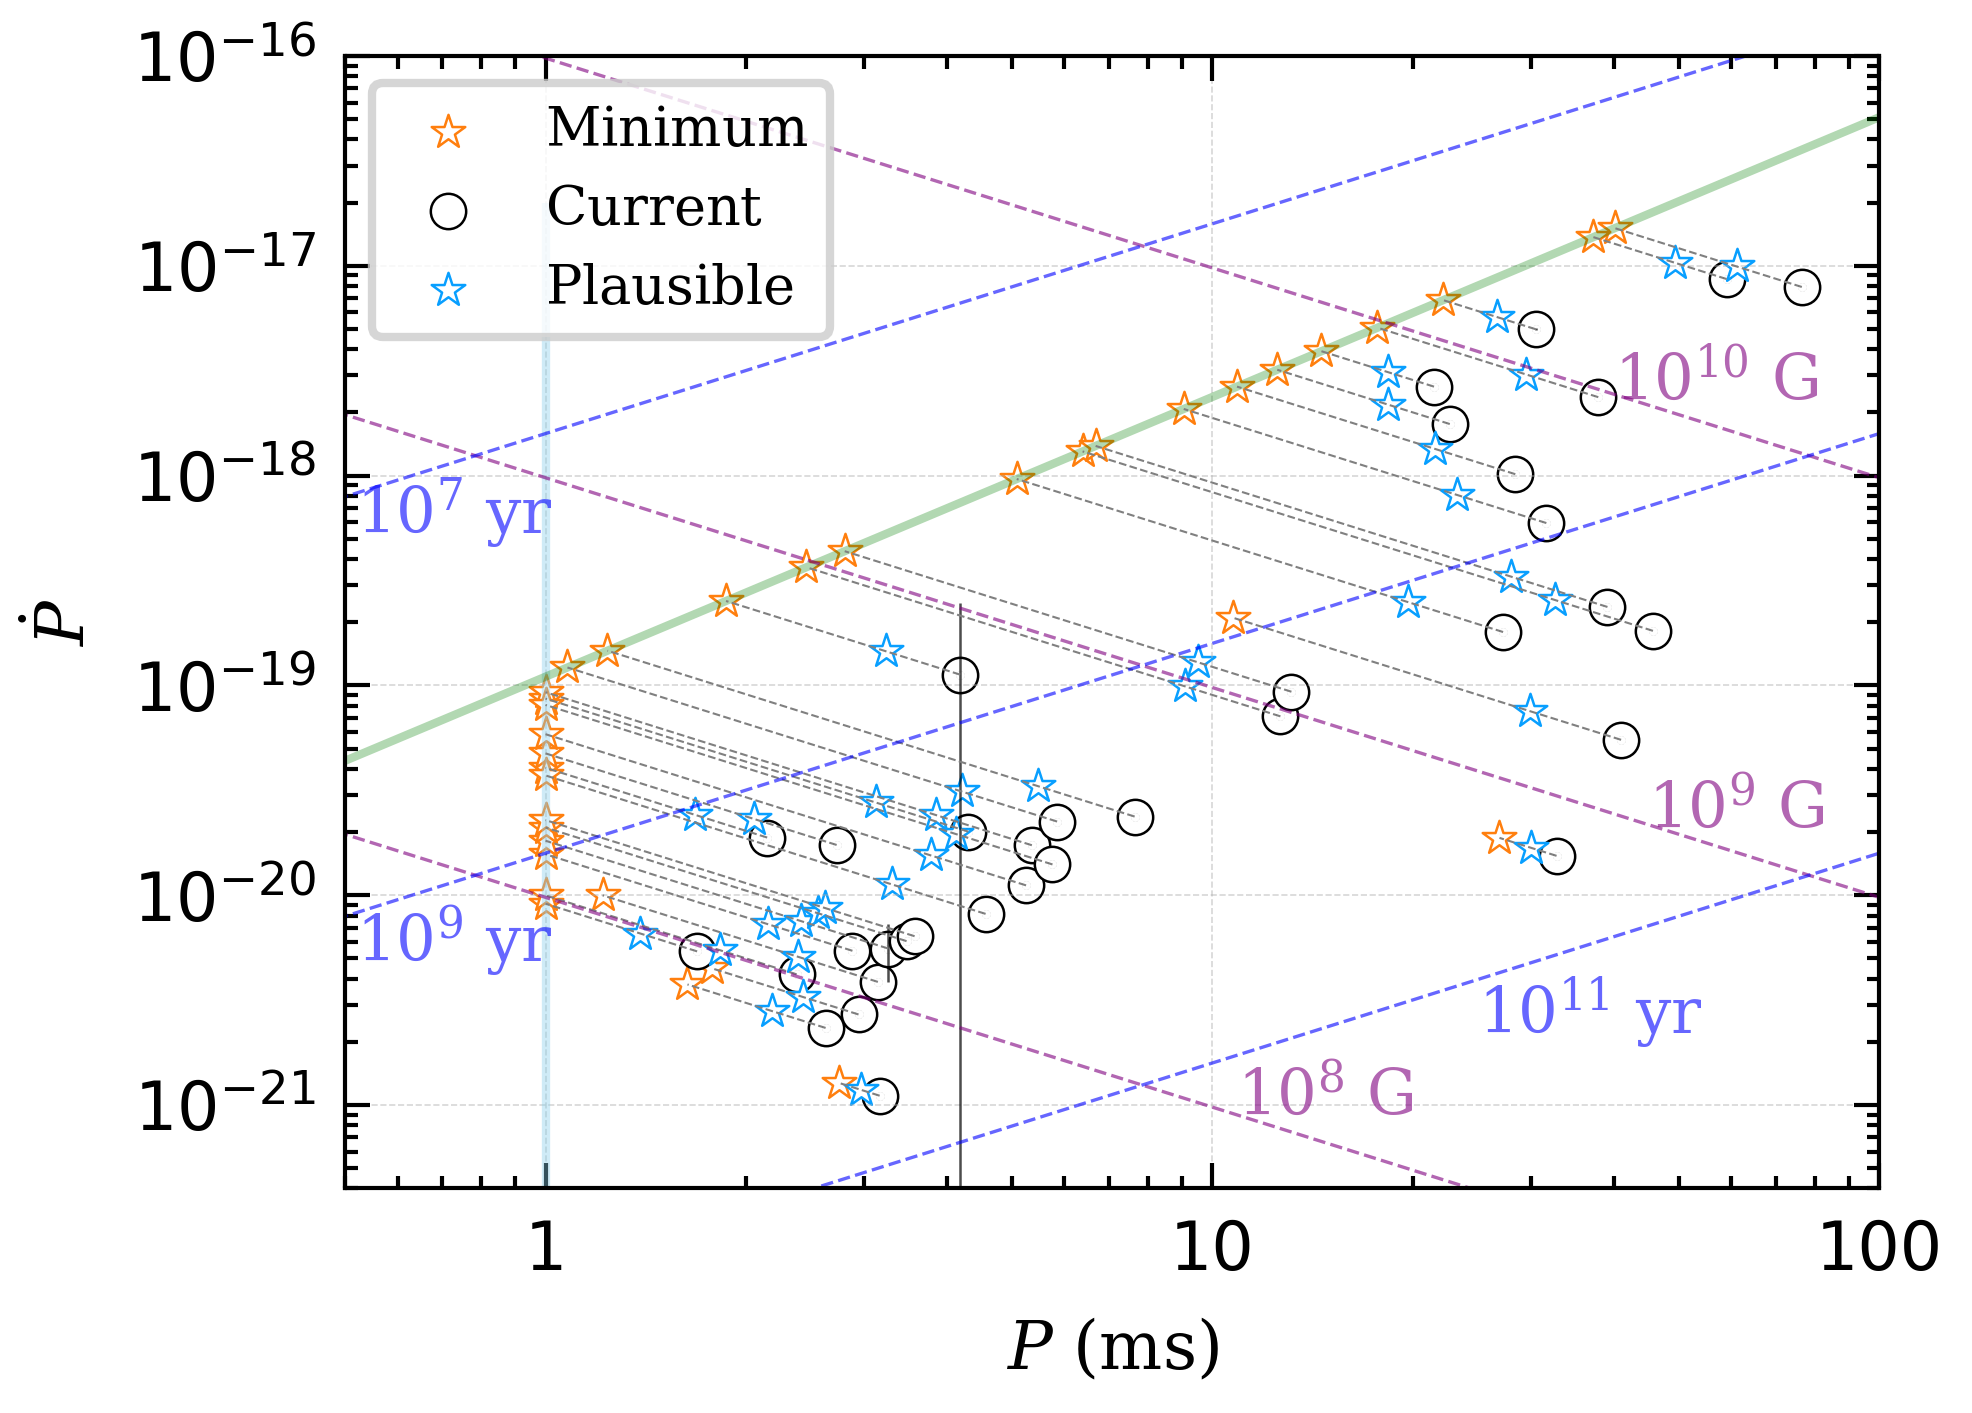

In [133]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['science','ieee','no-latex'])
p_arr=np.linspace(0.0001,20,10000)
p=np.linspace(0.0001,20,10000)
fs=7.5
ybeg=0.001
al=0.6
pdot_arr=p_pdot_forb(p_arr)
ms=18

plt.figure()
plt.grid(b=True, which='major',linestyle='--',lw=0.2,alpha=0.5)
#plt.grid(b=True,linestyle='--',lw=0.2,alpha=0.8)

#plt.scatter(p_min,pdot_min,marker='o',facecolor='white',edgecolors='green',lw=0.3,s=8,label=r'$\rm{birth_{min}}$')
plt.plot( p_arr, pdot_arr,c='green',alpha=0.3)
plt.scatter(data_a['p0_birth_lim'], data_a['p1_birth_lim'],marker='*',facecolor='white',edgecolors='#ff7f0e',lw=0.3,s=ms,label=r'$\rm{Minimum}$')
for i in range(len(data_a['p0'])):
    plt.plot([data_a['p0'][i],data_a['p0_birth_lim'][i]],[data_a['pdot_int'][i],data_a['p1_birth_lim'][i]],linewidth=0.25,ls='--',color='grey',alpha=1)

plt.scatter(data_a['p0'],data_a['pdot_int'],marker='o',facecolor='white',edgecolors='k',lw=0.3,s=ms,label=r'$\rm{Current}$')

plt.errorbar(data_a['p0'],data_a['pdot_int'],yerr=err_gc,marker="o",ms=0.001, color='k',lw=0.3,alpha=0.7,linestyle="none")

plt.scatter(p0_m,p1_m,marker='*',facecolor='white',edgecolors='#089FFF',lw=0.3,s=ms,label=r'$\rm{Plausible}$')



###plot age line and magnitude line######
plt.plot(p,pdot_mag(p,10**8),color='purple',ls='--',lw=0.4,alpha=al)
plt.plot(p,pdot_mag(p,10**9),color='purple',ls='--',lw=0.4,alpha=al)
plt.plot(p,pdot_mag(p,10**10),color='purple',ls='--',lw=0.4,alpha=al)
plt.text(10.9*10**(-3), 0.9*10**(-21), r'$\rm{10^{8} \,\, G}$', fontsize=fs, color='purple',alpha=al)
plt.text(4.5*10**(-2), 2.1*10**(-20), r'$\rm{10^{9} \,\, G}$', fontsize=fs, color='purple',alpha=al)
plt.text(4*10**(-2), 2.3*10**(-18), r'$\rm{10^{10} \,\, G}$', fontsize=fs, color='purple',alpha=al)


plt.plot(p,pdot_year(p,10**11),color='blue',ls='--',lw=0.4,alpha=al)
plt.plot(p,pdot_year(p,10**9),color='blue',ls='--',lw=0.4,alpha=al)
plt.plot(p,pdot_year(p,10**7),color='blue',ls='--',lw=0.4,alpha=al)
#plt.plot(p,pdot_year(p,10**10),color='red',ls='--',lw=0.4,alpha=al) #check line for 10Gyr
plt.text(0.025, 2.2*10**(-21), r'$\rm{10^{11} \,\, yr}$', fontsize=fs, color='blue',alpha=al)
plt.text(5.2*10**(-4), 4.8*10**(-21), r'$\rm{10^{9} \,\, yr}$', fontsize=fs, color='blue',alpha=al)
plt.text(5.2*10**(-4), 5.3*10**(-19), r'$\rm{10^{7} \,\, yr}$', fontsize=fs, color='blue',alpha=al)

plt.vlines(0.001,10**(-22),2*10**(-17),color='skyblue',alpha=0.4)

plt.xscale('log')
plt.yscale('log')
plt.legend(frameon=True,fontsize=6.5)
plt.xlabel(r'${P\,\,(\rm{ms})}$')
plt.ylabel(r'$\dot{P}$')
bbox_inches='tight'

locs, labels = plt.xticks()  # Get the current locations and labels.
plt.xticks([1.e-5, 1.e-4, 1.e-3, 1.e-2, 1.e-1, 1.e+0, 1.e+1],['0.01','0.1','1','10','100','1000','10000'])
plt.xlim([5.e-4,1.e-1])
plt.ylim([4*10**(-22),10*10**(-17)])
plt.savefig('p0p1_n3_ms_err.jpg')
plt.show()

In [139]:
def p1_spin_up(p1):
    """
    spin-up line (because the pdot of birth equals to the pdot of current, we need the period of birth)
    papramaters:
    ---
    the pdot
    ---
    return: the period, unit=s 
    """
    return (p1/(1.1*10**(-15)))**(3/4)

def p_birth_lim(p0,p1,tr):
    """
    obtain the period of birth given current P, Pdot and age
    paramaters:
    ---
    p0: the observed period, unit = s
    p1: the dp/dt of observation, unit = none 
    tr: random age from observation to birth
    ---
    return: the birth period, unit = s
    """
    return -p1*tr + p0

def p1_birth_lim(p0,p1,tr):
    """
    obtain the pdot of birth given current P, Pdot and age
    paramaters:
    ---
    p0: the observed period, unit = s
    p1: the dp/dt of observation, unit = none 
    tr: random age from observation to birth
    ---
    return: the birth Pdot, unit = none (for n=2, pdot_observation=pdot_birth)
    """
    return p1 + 0 * p0 + 0 * tr 

p0_lim_nswd=p_birth_lim(rec_nswd['p0'],rec_nswd['pdot_int'],rec_nswd['tmax']*u.Gyr.to(u.s))
p1_lim_nswd=p1_birth_lim(rec_nswd['p0'],rec_nswd['pdot_int'],rec_nswd['tmax']*u.Gyr.to(u.s))
p0_lim_psr=p_birth_lim(rec_psr['p0'],rec_psr['pdot_int'],rec_psr['tmax']*u.Gyr.to(u.s))
p1_lim_psr=p1_birth_lim(rec_psr['p0'],rec_psr['pdot_int'],rec_psr['tmax']*u.Gyr.to(u.s))

p0_lim_nswd=pd.DataFrame(p0_lim_nswd,columns=['p0_birth_lim'])
p1_lim_nswd=pd.DataFrame(p1_lim_nswd,columns=['p1_birth_lim'])
p0_lim_psr=pd.DataFrame(p0_lim_psr,columns=['p0_birth_lim'])
p1_lim_psr=pd.DataFrame(p1_lim_psr,columns=['p1_birth_lim'])

rec_nswd=pd.concat([rec_nswd,p0_lim_nswd],axis=1)
rec_nswd=pd.concat([rec_nswd,p1_lim_nswd],axis=1)
rec_psr=pd.concat([rec_psr,p0_lim_psr],axis=1)
rec_psr=pd.concat([rec_psr,p1_lim_psr],axis=1)

mcer=np.zeros(len(rec_nswd['p0']))
mcer=pd.DataFrame(mcer,columns=['mcerr'])
rec_nswd=pd.concat([rec_nswd,mcer],axis=1)

rec_psr_a=rec_psr[['name','m','merr','mc','mcerr','p0','p1','pb','pmra','pmdec','gl','gb','dl','pdot_int','tc','p0_birth_lim','p1_birth_lim','tc_b','tmax']]
rec_nswd_a=rec_nswd[['name','m','merr','mc','mcerr','p0','p1','pb','pmra','pmdec','gl','gb','dl','pdot_int','tc','p0_birth_lim','p1_birth_lim','tc_b','tmax']]
data_a=(pd.concat([rec_psr_a,rec_nswd_a.reset_index(drop=True)],axis=0)).reset_index(drop=True)

import astropy
import astropy.units as u 
import bilby

nu=len(data_a['m'])
ns=5000
t_u=np.zeros(nu*ns)
p0_ns=np.zeros(nu*ns)
pdot_int_ns=np.zeros(nu*ns)

for i in range(nu):
    t_u[i*5000:(i+1)*5000]=np.random.uniform(0,(data_a['tmax'][i]),5000)            #unit Gyr
    p0_ns[i*5000:(i+1)*5000]=np.ones(ns)*data_a['p0'][i]                             #unit s
    pdot_int_ns[i*5000:(i+1)*5000]=np.ones(ns)*data_a['pdot_int'][i]                 #unit s*s-1
t_u=t_u*u.Gyr.to(u.s)

pran=np.zeros(nu*ns)
p1ran=np.zeros(nu*ns)
pran=p_birth_lim(p0_ns,pdot_int_ns,t_u)
p1ran=p1_birth_lim(p0_ns,pdot_int_ns,t_u)

p_birth_mean=np.zeros(nu)
p1_birth_mean=np.zeros(nu)
for i in range(nu):
    p_birth_mean[i]=np.mean(pran[i*5000:(i+1)*5000])
    p1_birth_mean[i]=data_a['pdot_int'][i]

def tauris_acc_m(p_eq):
    """
    calculate an accreted mass given an equilibrium period
    using an initial mass of 1.4 M_Sun
    see https://arxiv.org/abs/1206.1862  Eq.14
    paramaters:
    -----
    p_eq: the period at equilibrium state, unit: s
    -----
    return :
    the accreted mass, unit: Solar mass
    """
    return 0.22*(1.4**(1/3))/(p_eq*1000)**(4/3)

delta_m_tau=np.zeros(nu*ns)
delta_m_tau=tauris_acc_m(pran)

def li_acc_m(p_eq):
    """
    calculate an accreted mass given an equilibrium period using the method in Li, Z.W., and et. al., 2021
    we fit the open circles in Figure 4. in arXiv:2108.02554v1, and obtain parameters: a = 0.28, b=-0.5.
    paramaters:
    -----
    p_eq: the period at equilibrium state, unit: s
    -----
    return :
    the accreted mass, unit: Solar mass
    
    """
    a=0.28
    b=-0.5
    return a*(p_eq*1000)**b

def errf(p_eq):
    """
    calculate the 1-sigma error for Li21
    the 1-sigma is defined as 1/3 times of the difference between Tauris12  and the best fitted line in Li21
    -----
    p_eq: the period at equilibrium state, unit: s
    -----
    return :
    the errors of the accreted mass, unit: Solar mass
    
    """
    return (li_acc_m(p_eq)-tauris_acc_m(p_eq))/3

delta_m_li=np.zeros(nu*ns)
delta_m_li=li_acc_m(pran)

delta_m_birth_ran=np.zeros(ns*nu)
delta_m_birth_ran=np.random.normal(delta_m_li,errf(pran),ns*nu)

data_exp_m_obs=np.zeros(ns*nu)
for i in range(len(data_a['m'])):
    data_exp_m_obs[i*5000:(i+1)*5000]=np.random.normal(data_a['m'][i],data_a['merr'][i],5000)
    
m_birth=data_exp_m_obs-delta_m_birth_ran
m_b_tau=data_exp_m_obs-delta_m_tau

nsl=13
slow_ns=np.zeros((nsl,2))
slow_ns[0,0]=1.27
slow_ns[0,1]=0.01
slow_ns[1,0]=1.291
slow_ns[1,1]=0.011
slow_ns[2:,0]=data_a['mc'][0:11]
slow_ns[2:,1]=data_a['mcerr'][0:11]
slow_exp=np.zeros(nsl*5000)
for i in range(nsl):
    slow_exp[i*5000:(i+1)*5000]=np.random.normal(slow_ns[i,0],slow_ns[i,1],5000)

rec_ns=np.zeros((35,2))
rec_ns[:,0]=np.array(data_a['m'])
rec_ns[:,1]=np.array(data_a['merr'])    
    
rec_slow_oran=np.zeros((ns*nu)+13*5000)
rec_slow_oran[0:(ns*nu)]=data_exp_m_obs
rec_slow_oran[(ns*nu):((ns*nu)+13*5000)]=slow_exp

rec_slow_cal=np.zeros((ns*nu)+13*5000)
rec_slow_cal[0:(ns*nu)]=m_birth
rec_slow_cal[(ns*nu):((ns*nu)+13*5000)]=slow_exp

rec_slow_cal_tau=np.zeros((ns*nu)+13*5000)
rec_slow_cal_tau[0:(ns*nu)]=m_b_tau
rec_slow_cal_tau[(ns*nu):((ns*nu)+13*5000)]=slow_exp

#np.savetxt('oran.txt',rec_slow_oran)
np.savetxt('cal_li_n2.txt',rec_slow_cal)
np.savetxt('cal_tau_n2.txt',rec_slow_cal_tau)

# Loading data

In [1]:
import numpy as np
import pandas as pd
rec_slow_oran_l=np.loadtxt('oran.txt')
rec_slow_cal_li_n3=np.loadtxt('cal_li.txt')
rec_slow_cal_tau_n3=np.loadtxt('cal_tau.txt')

rec_slow_oran_la=np.loadtxt('oran.txt')
rec_slow_cal_li_n2 =np.loadtxt('cal_li_n2.txt')
rec_slow_cal_tau_n2=np.loadtxt('cal_tau_n2.txt')

ns=int(len(rec_slow_oran_l)/5000)

rec_slow_oran_l_mean = np.zeros(ns)
rec_slow_cal_li_n3_mean =np.zeros(ns)
rec_slow_cal_tau_n3_mean =np.zeros(ns)

rec_slow_oran_la_mean =np.zeros(ns)
rec_slow_cal_li_n2_mean =np.zeros(ns)
rec_slow_cal_tau_n2_mean =np.zeros(ns)

for i in range(ns):
    rec_slow_oran_l_mean[i]=np.mean(rec_slow_oran_l[i*5000:(i+1)*5000] )
    rec_slow_cal_li_n3_mean[i]=np.mean(rec_slow_cal_li_n3[i*5000:(i+1)*5000] )
    rec_slow_cal_tau_n3_mean[i]=np.mean(rec_slow_cal_tau_n3[i*5000:(i+1)*5000] )
    
    rec_slow_oran_la_mean[i]=np.mean(rec_slow_oran_la[i*5000:(i+1)*5000] )
    rec_slow_cal_li_n2_mean[i]=np.mean(rec_slow_cal_li_n2[i*5000:(i+1)*5000] )
    rec_slow_cal_tau_n2_mean[i]=np.mean(rec_slow_cal_tau_n2[i*5000:(i+1)*5000] )

# Comparing the histogram for n=2 and n=3 using li21 and Tau12 method

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times


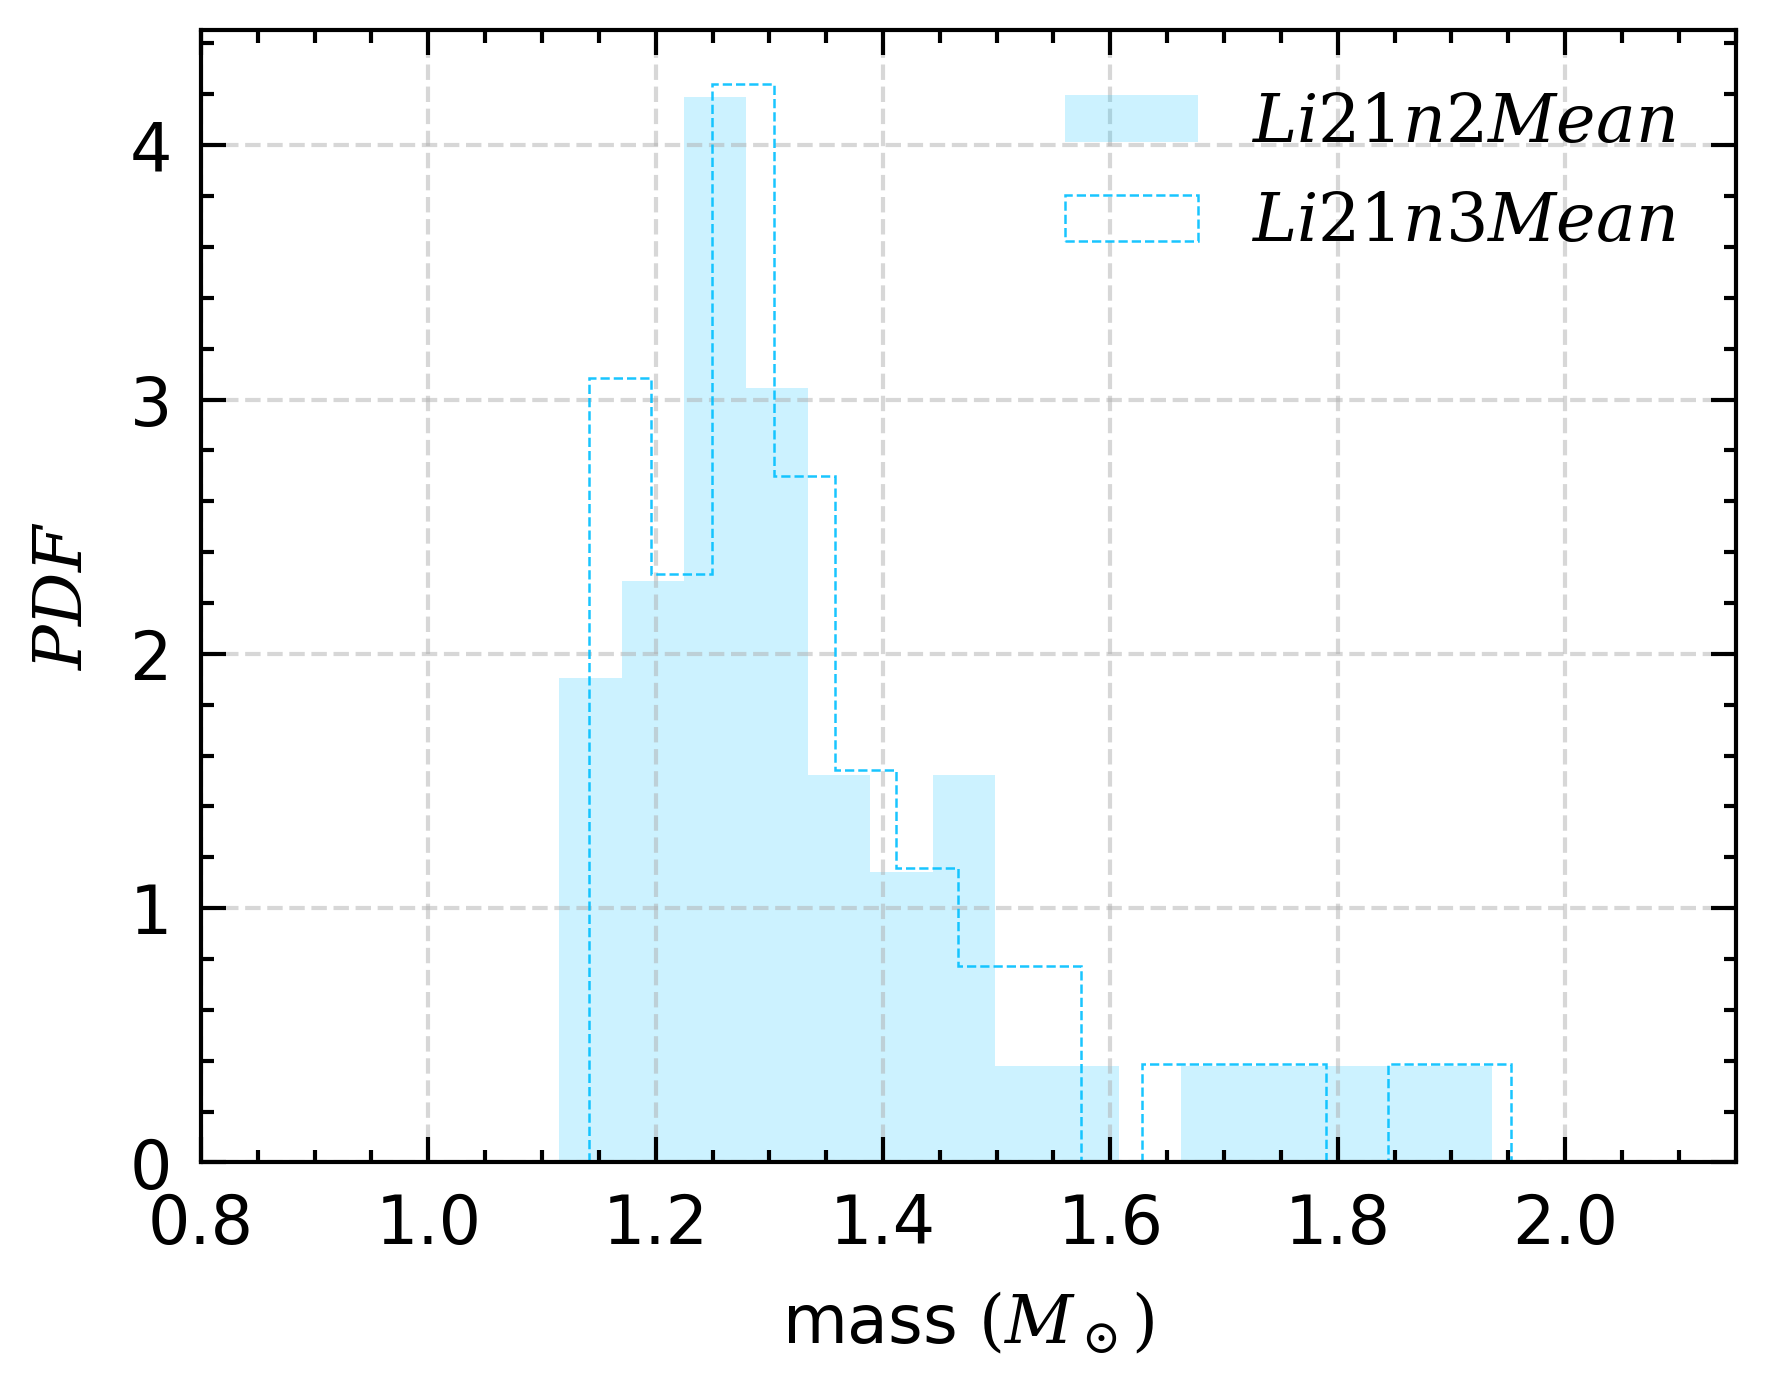

In [3]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
plt.style.use(['science','ieee','no-latex'])

bwa=4
plt.figure()
plt.grid(linestyle='--',alpha=0.5)
#plt.hist(rec_slow_cal_li_n2,histtype='bar',bins=20,density=True,lw=0.3,ls='--',color='grey',alpha=0.6,label=r'$Li 21 n 2$')
#plt.hist(rec_slow_cal_li_n3,histtype='step',bins=20,density=True,lw=0.3,ls='--',color='k',alpha=0.8,label=r'$Li21n3$')

plt.hist(rec_slow_cal_li_n2_mean,histtype='bar',bins=15,density=True,lw=0.3,ls='--',color='deepskyblue',alpha=0.2,label=r'$Li 21 n 2Mean$')
plt.hist(rec_slow_cal_li_n3_mean,histtype='step',bins=15,density=True,lw=0.3,ls='--',color='deepskyblue',alpha=0.9,label=r'$Li21n3Mean$')

plt.xlabel('mass $(M_\odot)$')
plt.ylabel('$PDF$')
plt.xlim([0.8,2.15])
#plt.ylim([0,4])
plt.legend()
bbox_inches='tight'
#plt.savefig('3_d_data.pdf')
plt.show()

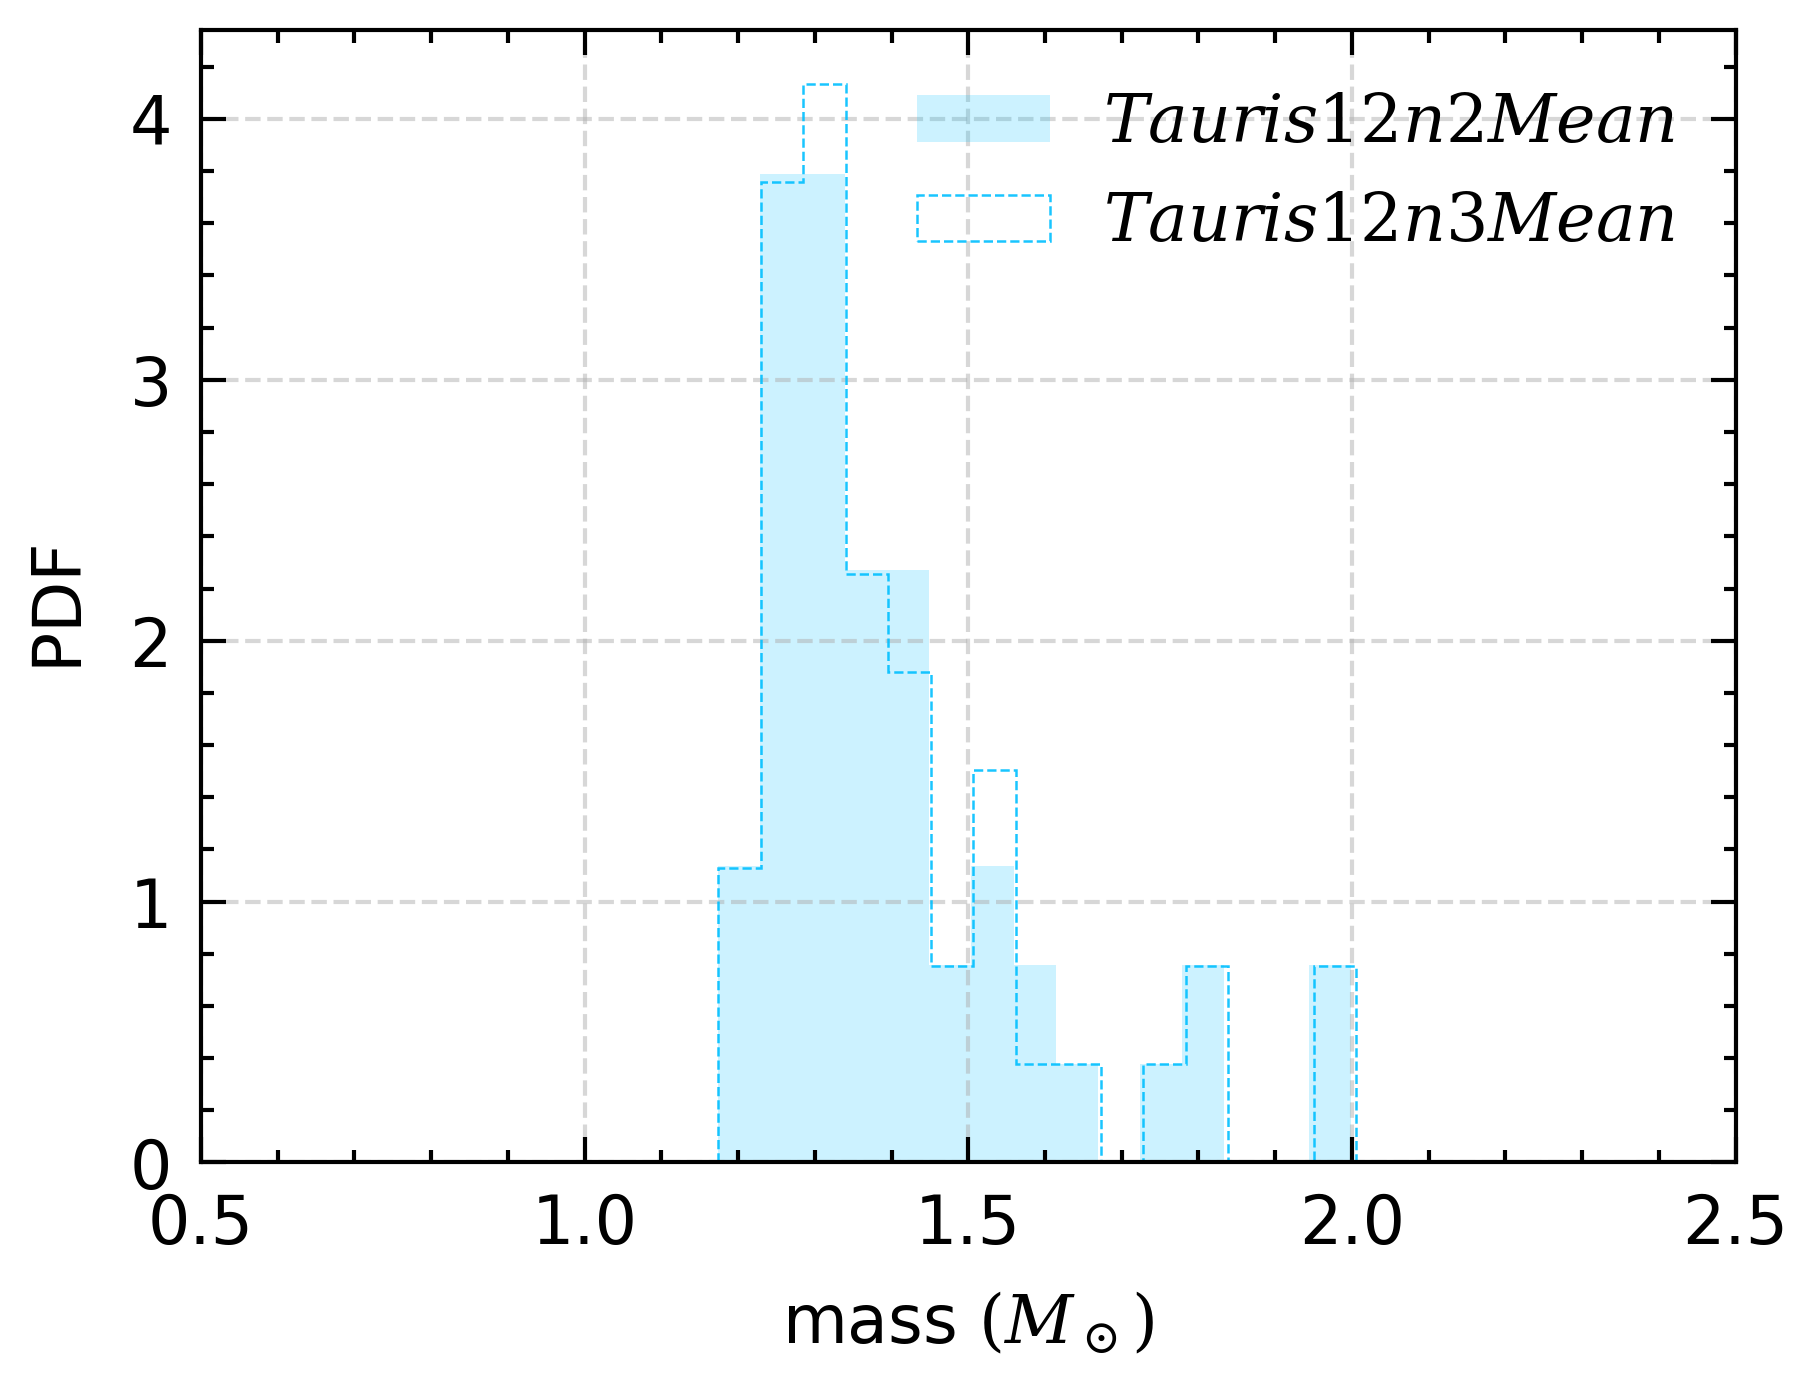

In [4]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline
plt.style.use(['science','ieee','no-latex'])

bwa=4
plt.figure()
plt.grid(linestyle='--',alpha=0.5)
#plt.hist(rec_slow_cal_tau_n2,histtype='bar',bins=20,density=True,lw=0.3,ls='--',color='grey',alpha=0.6,label=r'$Tauris 12 n 2$')
#plt.hist(rec_slow_cal_tau_n3,histtype='step',bins=20,density=True,lw=0.3,ls='--',color='k',alpha=0.8,label=r'$Tauris12n3$')

plt.hist(rec_slow_cal_tau_n2_mean,histtype='bar',bins=15,density=True,lw=0.3,ls='--',color='deepskyblue',alpha=0.2,label=r'$Tauris 12 n 2Mean$')
plt.hist(rec_slow_cal_tau_n3_mean,histtype='step',bins=15,density=True,lw=0.3,ls='--',color='deepskyblue',alpha=0.9,label=r'$Tauris12n3Mean$')

plt.xlabel('mass $(M_\odot)$')
plt.ylabel('PDF ')
plt.xlim([0.5,2.5])
#plt.ylim([0,4])
plt.legend()
bbox_inches='tight'
#plt.savefig('3_d_data.pdf')
plt.show()

In [82]:
import pandas as pd
import numpy as np
comp_show=np.zeros((2,2))
comp_show[0,0] = np.mean(rec_slow_cal_li_n2_mean)
comp_show[0,1] = np.mean(rec_slow_cal_li_n3_mean)
comp_show[1,0] = np.mean(rec_slow_cal_tau_n2_mean)
comp_show[1,1] = np.mean(rec_slow_cal_tau_n3_mean)
df_comp_show=pd.DataFrame(comp_show,columns= ['n=2','n=3'],index=['Li','Tau'])

# Comparing the mean value for HF(li21), HF2(li21,n=2), LF(tau12) and LF2(tau12,n=2)

In [83]:
df_comp_show

,n=2,n=3
Li,1.359229,1.355949
Tau,1.417950,1.413815


In [5]:
rec_li_n2 =np.loadtxt('cal_li_n2.txt')
rec_li_n3=np.loadtxt('cal_li.txt')

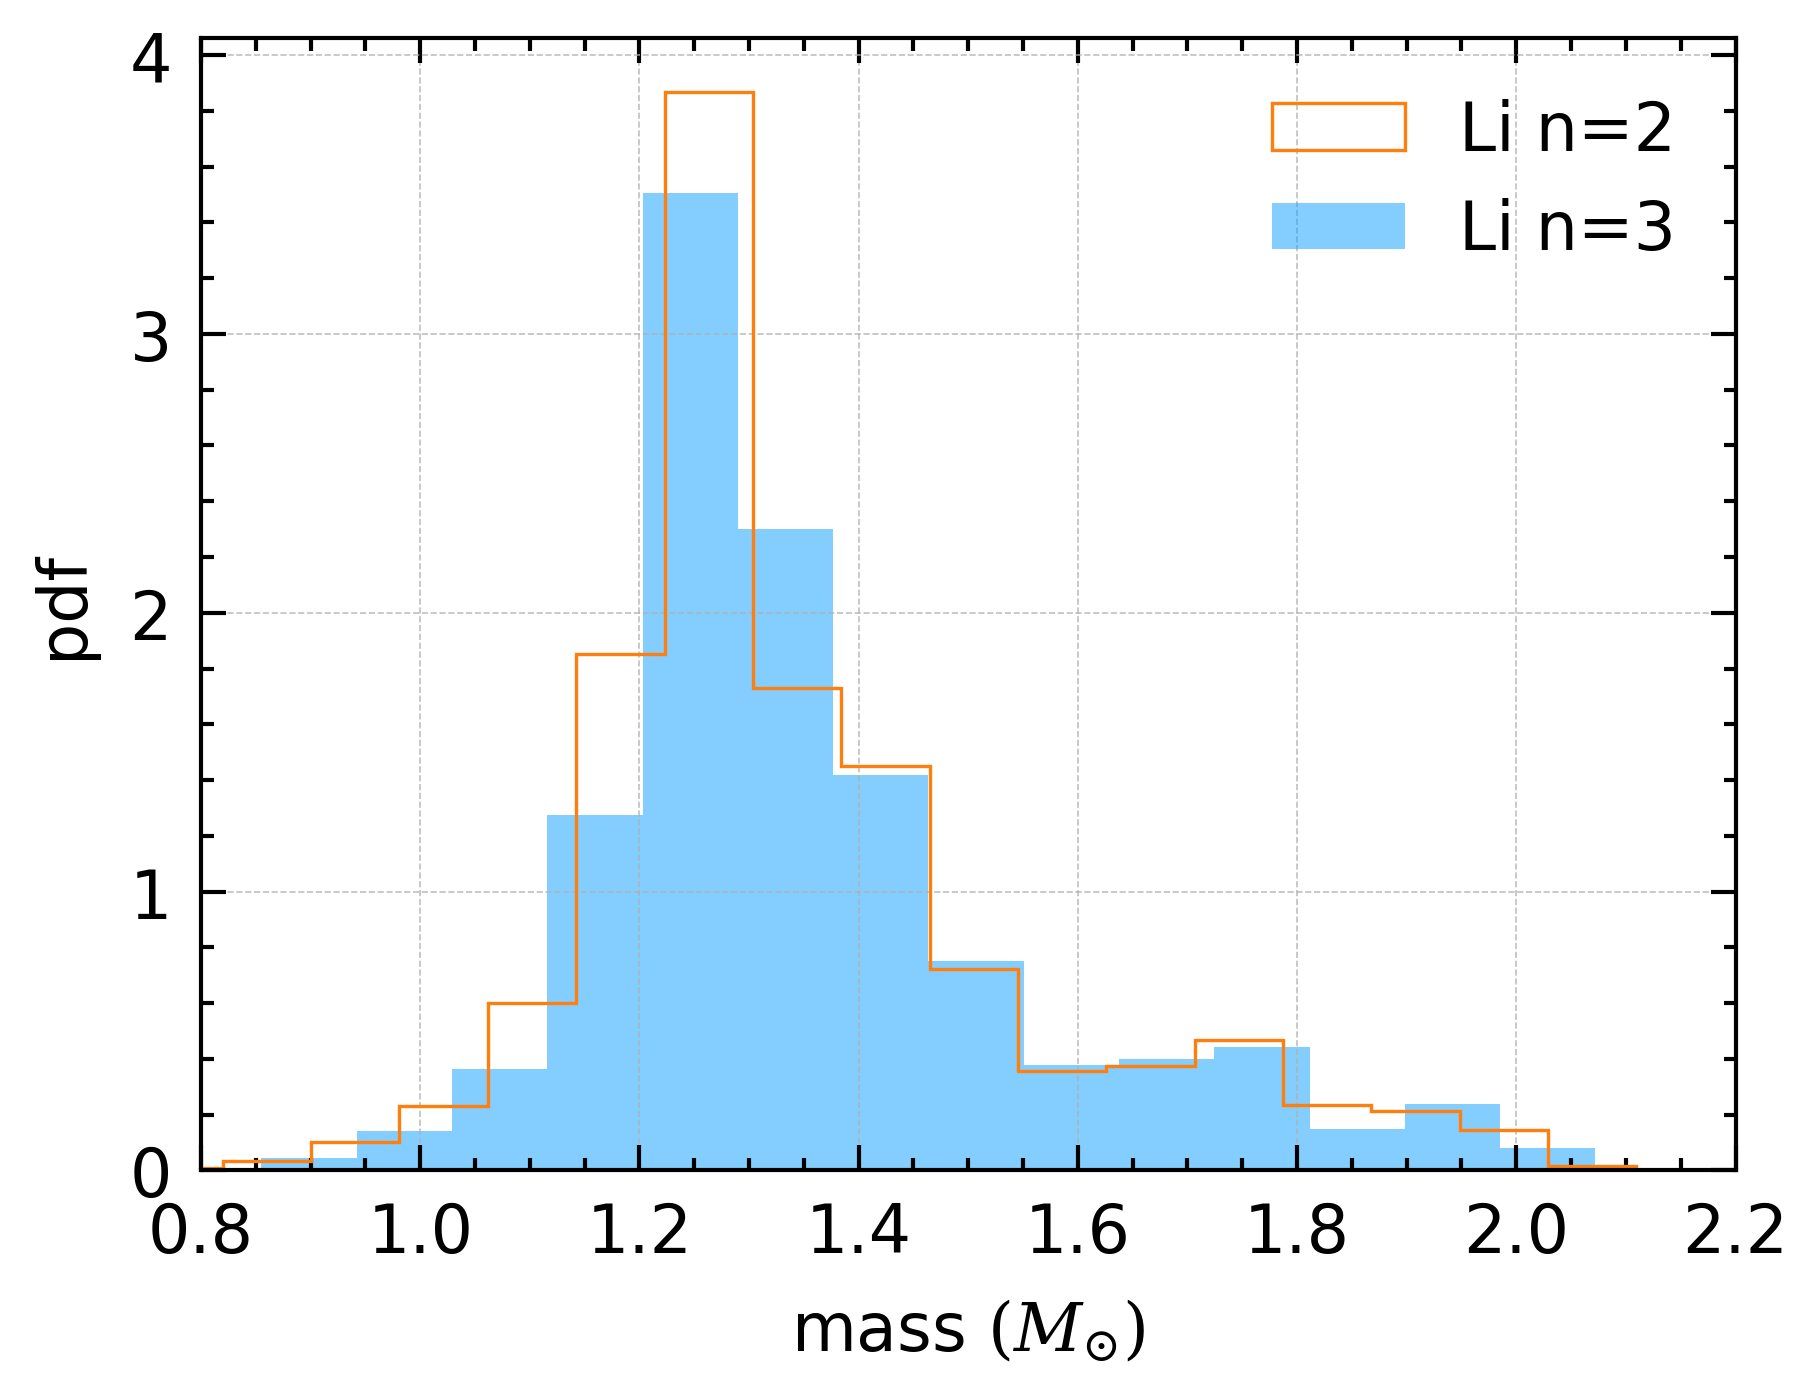

In [18]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['science','ieee','no-latex'])

plt.grid(b=True,linestyle='--',lw=0.2,alpha=0.8)
plt.hist(rec_li_n2,density=True,histtype='step',bins=20,lw=0.4,color='#ff7f0e',label=r'Li n=2')
plt.hist(rec_li_n3,density=True,histtype='bar',ls=':',bins=20,lw=0.4,alpha=0.5,color='#089FFF',label=r'Li n=3')


rec_li_n2_mean=np.zeros(48)
rec_li_n3_mean=np.zeros(48)
for i in range(48):
    rec_li_n2_mean[i]=np.mean(rec_li_n2[i*5000:(i+1)*5000])
    rec_li_n3_mean[i]=np.mean(rec_li_n3[i*5000:(i+1)*5000])
    
#plt.hist(rec_li_n2_mean,density=True,histtype='bar',bins=15,lw=0.4,color='deepskyblue',label=r'Li n=2 mean')
#plt.hist(rec_li_n3_mean,density=True,histtype='step',ls=':',bins=15,lw=0.4,alpha=0.5,color='#089FFF',label=r'Li n=3 mean')

    
plt.xlabel(r'mass $(M_{\odot})$')
plt.ylabel(r'pdf')
plt.xlim(0.8,2.2)
plt.legend(loc='upper right')
plt.savefig('li_n2_n3.pdf')

In [7]:
tau_n2 =np.loadtxt('cal_tau_n2.txt')
rec_tau_n3=np.loadtxt('cal_tau.txt')

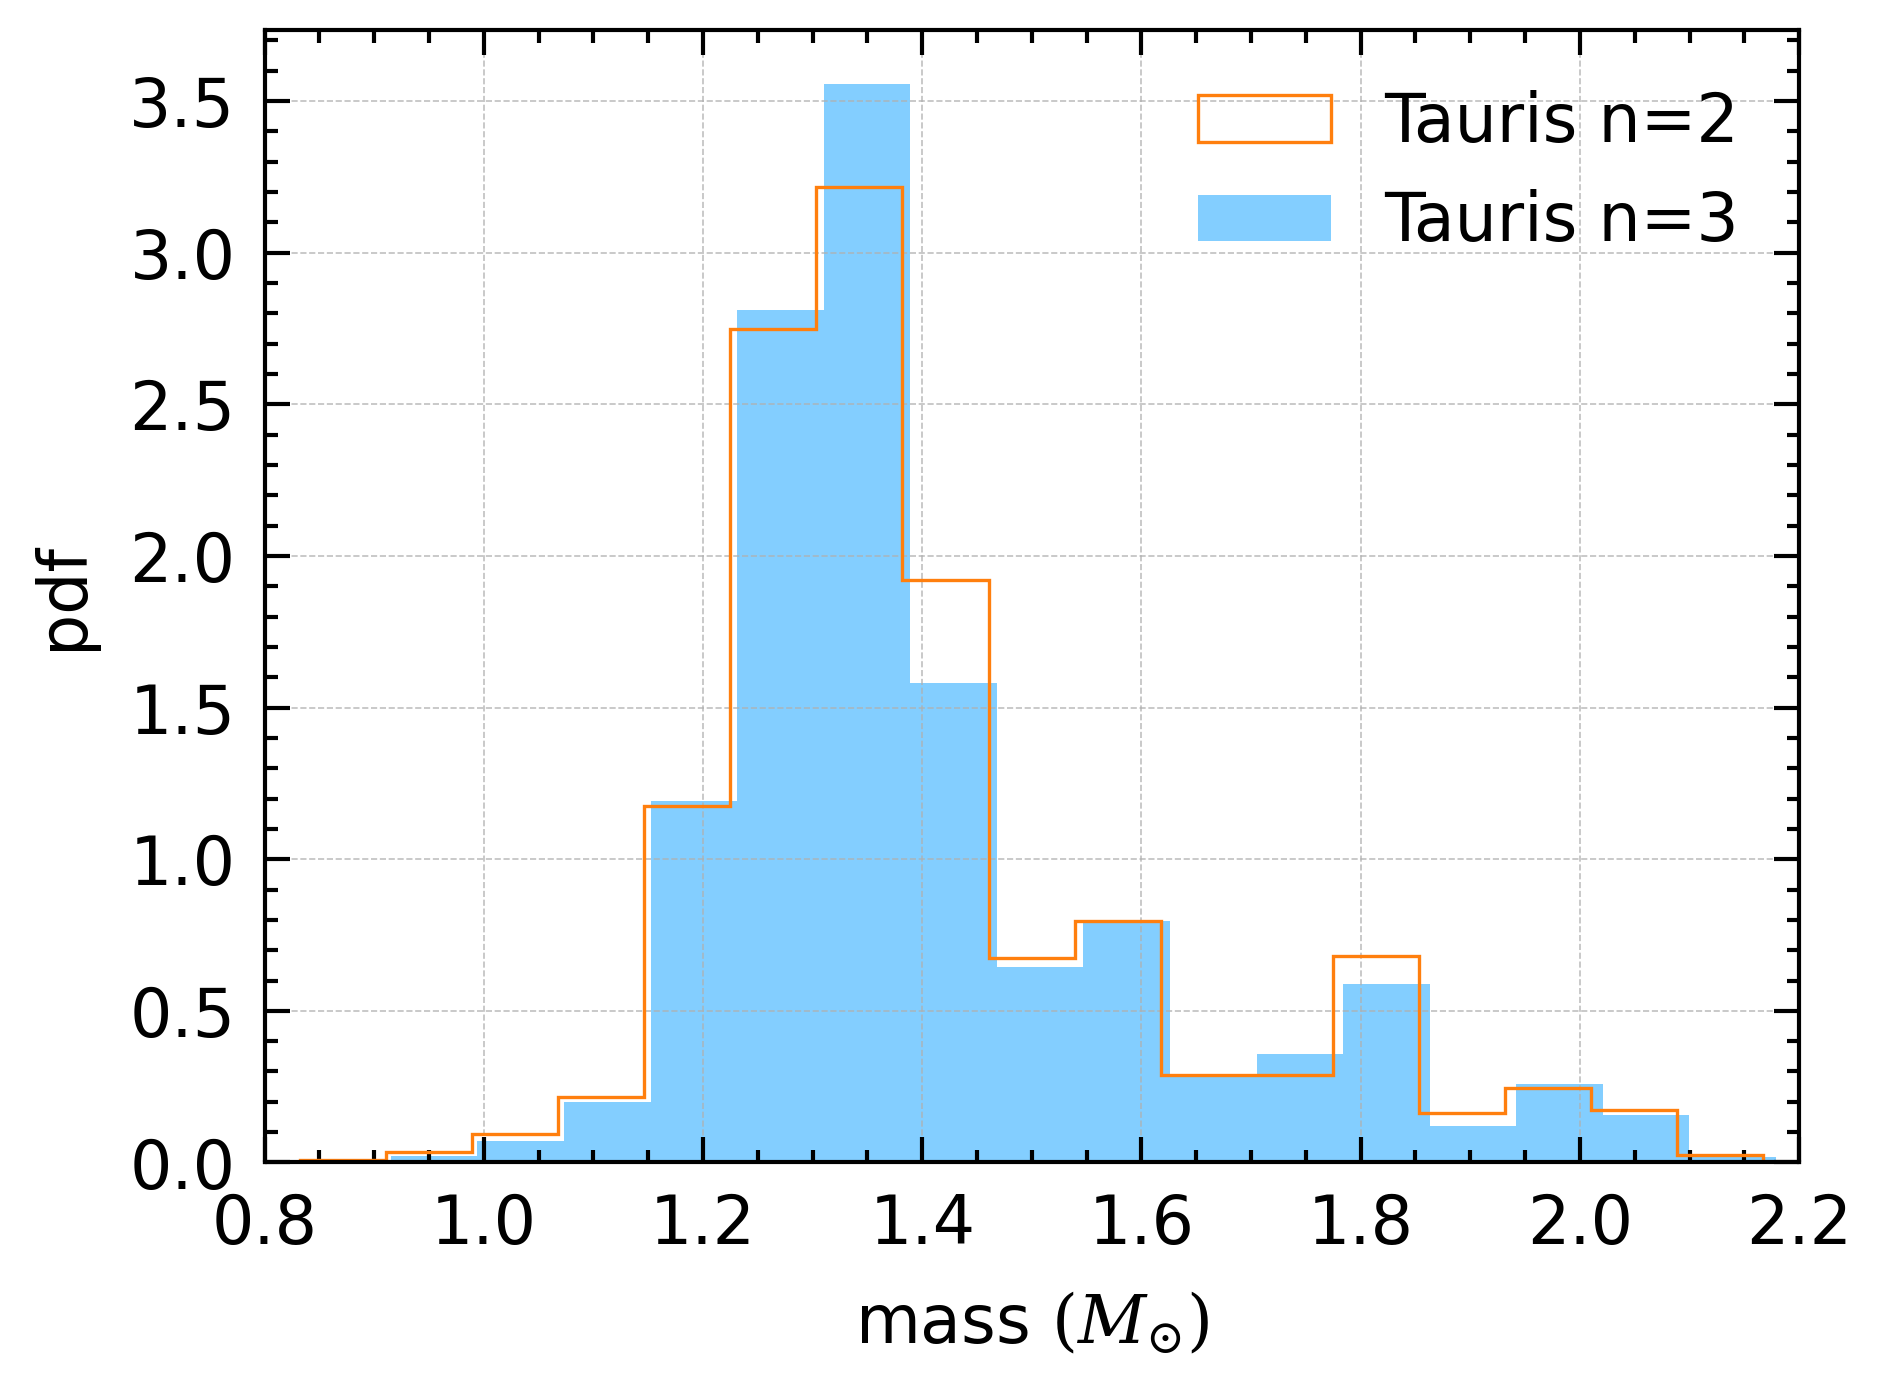

In [8]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['science','ieee','no-latex'])

plt.grid(b=True,linestyle='--',lw=0.2,alpha=0.8)

plt.hist(tau_n2,density=True,histtype='step',bins=20,lw=0.4,color='#ff7f0e',label=r'Tauris n=2')
plt.hist(rec_tau_n3,density=True,histtype='bar',ls=':',bins=20,lw=0.4,alpha=0.5,color='#089FFF',label=r'Tauris n=3')

plt.xlabel(r'mass $(M_{\odot})$')
plt.ylabel(r'pdf')
plt.xlim(0.8,2.2)
plt.legend(loc='upper right')
plt.savefig('tau_n2_n3.pdf')